In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype
from sklearn.preprocessing import Imputer, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc

In [38]:
diab = pd.read_csv("diabetes_explore2.csv") 
print (diab.head(10) )

diab.info()
print("aggregate statistics:")
diab.describe()

   preg  plas  pres  skin  insu  mass   pedi  age  class age_level
0     6   148    72    35     0  33.6  0.627   50      1       50s
1     1    85    66    29     0  26.6  0.351   31      0       30s
2     8   183    64     0     0  23.3  0.672   32      1       30s
3     1    89    66    23    94  28.1  0.167   21      0       20s
4     0   137    40    35   168  43.1  2.288   33      1       30s
5     5   116    74     0     0  25.6  0.201   30      0       30s
6     3    78    50    32    88  31.0  0.248   26      1       20s
7    10   115     0     0     0  35.3  0.134   29      0       20s
8     2   197    70    45   543  30.5  0.158   53      1       50s
9     8   125    96     0     0   0.0  0.232   54      1       50s
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
preg         768 non-null int64
plas         768 non-null int64
pres         768 non-null int64
skin         768 non-null int64
insu         768 non-null int6

,preg,plas,pres,skin,insu,mass,pedi,age,class
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [39]:
print(diab.age_level.unique())
print("counts of age_level:")
print(diab['age_level'].value_counts())

['50s' '30s' '20s' '40s' '60+']
counts of age_level:
20s    396
30s    165
40s    118
50s     57
60+     32
Name: age_level, dtype: int64


In [40]:
# data cleaning
# not cleaning preg= 17: assumption that mother can be pregnant 
# (pregnancies & miscarriages) 17 times is not impossible 
# plasma=0, pres=0, skin=0, insu=0, mass=0
diab1 = diab.copy(deep=True)
diab1['plas'] = diab1['plas'].replace(0,np.NaN)
diab1['pres'] = diab1['pres'].replace(0,np.NaN)
diab1['skin'] = diab1['skin'].replace(0,np.NaN)
diab1['insu'] = diab1['insu'].replace(0,np.NaN)
diab1['mass'] = diab1['mass'].replace(0,np.NaN)
print("aggregate statistics after data cleaning:")
diab1.describe()

aggregate statistics after data cleaning:


,preg,plas,pres,skin,insu,mass,pedi,age,class
count,768.000000,763.000000,733.000000,541.000000,394.000000,757.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,155.548223,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.535641,12.382158,10.476982,118.775855,6.924988,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,22.000000,76.250000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,141.000000,80.000000,36.000000,190.000000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [41]:
#  dropping age_level, since it's a derived column from variable age, with high correlation
# splitting test & train data set
X = diab1.drop(labels=['class', 'age_level'], axis=1)
print ("X", X)

y = diab1.loc[:,'class'] # alt: use iloc for index based data selection
print (y)

print (y.unique())
X_col_names = X.columns.values
X_col_names

X      preg   plas  pres  skin   insu  mass   pedi  age
0       6  148.0  72.0  35.0    NaN  33.6  0.627   50
1       1   85.0  66.0  29.0    NaN  26.6  0.351   31
2       8  183.0  64.0   NaN    NaN  23.3  0.672   32
3       1   89.0  66.0  23.0   94.0  28.1  0.167   21
4       0  137.0  40.0  35.0  168.0  43.1  2.288   33
..    ...    ...   ...   ...    ...   ...    ...  ...
763    10  101.0  76.0  48.0  180.0  32.9  0.171   63
764     2  122.0  70.0  27.0    NaN  36.8  0.340   27
765     5  121.0  72.0  23.0  112.0  26.2  0.245   30
766     1  126.0  60.0   NaN    NaN  30.1  0.349   47
767     1   93.0  70.0  31.0    NaN  30.4  0.315   23

[768 rows x 8 columns]
0      1
1      0
2      1
3      0
4      1
      ..
763    0
764    0
765    0
766    1
767    0
Name: class, Length: 768, dtype: int64
[1 0]


array(['preg', 'plas', 'pres', 'skin', 'insu', 'mass', 'pedi', 'age'],
      dtype=object)

In [42]:
# pre-processing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1,stratify=y)
print(X_train)
print(len(X_train),len(y_train))
print(len(X_test),len(y_test))

     preg   plas  pres  skin   insu  mass   pedi  age
216     5  109.0  62.0  41.0  129.0  35.8  0.514   25
556     1   97.0  70.0  40.0    NaN  38.1  0.218   30
540     8  100.0  74.0  40.0  215.0  39.4  0.661   43
697     0   99.0   NaN   NaN    NaN  25.0  0.253   22
340     1  130.0  70.0  13.0  105.0  25.9  0.472   22
..    ...    ...   ...   ...    ...   ...    ...  ...
721     1  114.0  66.0  36.0  200.0  38.1  0.289   21
326     1  122.0  64.0  32.0  156.0  35.1  0.692   30
712    10  129.0  62.0  36.0    NaN  41.2  0.441   38
137     0   93.0  60.0  25.0   92.0  28.7  0.532   22
645     2  157.0  74.0  35.0  440.0  39.4  0.134   30

[537 rows x 8 columns]
537 537
231 231


In [43]:
# imputing Nan's with medians in X_train and X_tests
imp_x = Imputer(missing_values='NaN', strategy='median', axis=0) 
X_train = imp_x.fit_transform(X_train)
X_test = imp_x.transform(X_test)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [44]:
# using kernel = rbf
svc = SVC(kernel='rbf', cache_size=1000, probability=True) 
print ("svc:", svc)

clf = svc.fit(X_train,y_train) # trains the classifier on the training set
y_pred = svc.predict(X_test) # tests the classifier on the test set
pTot = accuracy_score(y_test, y_pred)
print ("Prediction accuracy: ", pTot)

svc: SVC(C=1.0, cache_size=1000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Prediction accuracy:  0.6493506493506493


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [45]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
report = classification_report(y_test, y_pred)
print (report) #for each class prints: precision  recall  f1-score   support

[[150   0]
 [ 81   0]]
              precision    recall  f1-score   support

           0       0.65      1.00      0.79       150
           1       0.00      0.00      0.00        81

    accuracy                           0.65       231
   macro avg       0.32      0.50      0.39       231
weighted avg       0.42      0.65      0.51       231



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [46]:
# minmax scaling
print (X_test) #compare before/after scaling
min_max_scaler = MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(X_train)# fit AND transform training set
X_test_minmax = min_max_scaler.transform(X_test)# test set transform only, no fit
X_test_minmax

[[  0.    131.     66.    ...  34.3     0.196  22.   ]
 [  0.    165.     90.    ...  52.3     0.427  23.   ]
 [  7.    102.     74.    ...  37.2     0.204  45.   ]
 ...
 [  1.    172.     68.    ...  42.4     0.702  28.   ]
 [  5.    158.     84.    ...  39.4     0.395  29.   ]
 [  4.    151.     90.    ...  29.7     0.294  36.   ]]


array([[0.        , 0.56493506, 0.45      , ..., 0.3907767 , 0.04794521,
        0.01666667],
       [0.        , 0.78571429, 0.75      , ..., 0.8276699 , 0.14683219,
        0.03333333],
       [0.41176471, 0.37662338, 0.55      , ..., 0.46116505, 0.05136986,
        0.4       ],
       ...,
       [0.05882353, 0.83116883, 0.475     , ..., 0.58737864, 0.26455479,
        0.11666667],
       [0.29411765, 0.74025974, 0.675     , ..., 0.51456311, 0.13313356,
        0.13333333],
       [0.23529412, 0.69480519, 0.75      , ..., 0.27912621, 0.08989726,
        0.25      ]])

In [47]:
svc = SVC(kernel='rbf', cache_size=1000, probability=True) 
print (svc)
clf = svc.fit(X_train_minmax, y_train) # trains the classifier on the training set
y_pred_minmax = svc.predict(X_test_minmax) # tests the classifier on the test set
pTot = accuracy_score(y_test, y_pred_minmax)
print ("Prediction accuracy: ",pTot)

SVC(C=1.0, cache_size=1000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Prediction accuracy:  0.7575757575757576


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [48]:
cm = confusion_matrix(y_test, y_pred_minmax)
print (cm)
report = classification_report(y_test, y_pred_minmax)
print (report)

[[136  14]
 [ 42  39]]
              precision    recall  f1-score   support

           0       0.76      0.91      0.83       150
           1       0.74      0.48      0.58        81

    accuracy                           0.76       231
   macro avg       0.75      0.69      0.71       231
weighted avg       0.75      0.76      0.74       231



In [49]:
# Parameter tuning: choosing gamma & C
C_range = 10.0 ** np.arange(-2, 4)
gamma_range = [.01, .1, 1, 'auto', 10, 100]
print (gamma_range)
param_grid = dict(gamma=gamma_range, C=C_range)
param_grid

[0.01, 0.1, 1, 'auto', 10, 100]


{'gamma': [0.01, 0.1, 1, 'auto', 10, 100],
 'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])}

In [50]:
# Default is 3-fold cross validation
grid = GridSearchCV(SVC(kernel='rbf',cache_size=1000, probability=True), param_grid=param_grid)  
grid.fit(X_train_minmax, y_train)
best_C = grid.best_estimator_.C
best_gamma = grid.best_estimator_.gamma
print ("The best C and gamma for rbf is: %.5f, %.5f " % (best_C, best_gamma))
grid.best_estimator_

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


The best C and gamma for rbf is: 100.00000, 0.10000 


SVC(C=100.0, cache_size=1000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [51]:
best_predict_minmax = grid.best_estimator_.predict(X_test_minmax)
pTot = accuracy_score(y_test, best_predict_minmax)
print("Prediction accuracy: ",pTot)
cm = confusion_matrix(y_test, best_predict_minmax)
print(cm)
report = classification_report(y_test, best_predict_minmax)
print(report)

Prediction accuracy:  0.7575757575757576
[[135  15]
 [ 41  40]]
              precision    recall  f1-score   support

           0       0.77      0.90      0.83       150
           1       0.73      0.49      0.59        81

    accuracy                           0.76       231
   macro avg       0.75      0.70      0.71       231
weighted avg       0.75      0.76      0.74       231



In [ ]:
# this is the best fit model for kernel = rbf using minmax scaled data
# using best value for parameters C = 100.00000, gamma = 0.10000 using the GridSearchCV
# this model has prediction accuracy = 0.757575 (75.75%)
# it's confusion matrix [[135  15] [ 41  40]]. (TP = 135, TN = 40, FP=41 and FN=15)
# the ROC curve is displayed below with its ROC area=0.81

In [53]:
# ROC curve
probas_ = svc.fit(X_train_minmax, y_train).predict_proba(X_test_minmax)
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
print ("thresholds", thresholds)
print ("probas_", probas_)
print ("AUC using predict_proba", roc_auc)

thresholds [1.98044043 0.98044043 0.95568325 0.94116902 0.90629417 0.90576592
 0.8767394  0.87479959 0.83037111 0.81713376 0.79464078 0.77785473
 0.73435349 0.7325467  0.71329089 0.71093351 0.68034909 0.66987222
 0.64380216 0.63375546 0.62748502 0.61603378 0.58965838 0.56449297
 0.55064479 0.52097865 0.51542516 0.51519669 0.51432871 0.48352345
 0.47455192 0.46556326 0.44033154 0.43369164 0.43295729 0.43027461
 0.42492623 0.42159002 0.41998408 0.39694958 0.37921188 0.37740922
 0.37720499 0.35594585 0.35491015 0.33843369 0.31764409 0.31752804
 0.31560072 0.30723428 0.3061119  0.29664579 0.29518199 0.28315441
 0.27185508 0.26969045 0.26642229 0.22942687 0.22793795 0.225638
 0.22210181 0.21607868 0.21544107 0.21145146 0.20752778 0.2058705
 0.19434499 0.19383472 0.19344289 0.19187431 0.19057341 0.15744875
 0.1566282  0.15524901 0.15518151 0.15327233 0.14872156 0.14591824
 0.1446394  0.13412329 0.13394481 0.09601976 0.09579041 0.04510231
 0.04360843 0.01885024]
probas_ [[0.79247222 0.2075277

/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


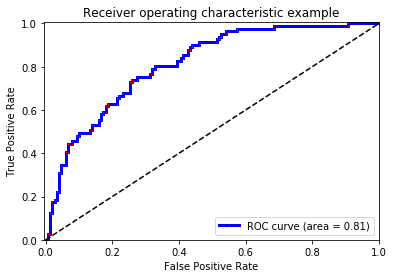

In [54]:
%matplotlib inline

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, lw=3, color ="#0000ff", marker='s',markerfacecolor="red", markersize=2) 
plt.plot([0, 1], [0, 1], 'k--')

# Setting x and y ranges, labels, title and legend
#x range basically from 0 to 1: start range a bit to left of min x value to see thick line better
plt.xlim([-0.005, 1.0])  
#0 range basically from 0 to 1: extend range a bit above max y value to see thick line better
plt.ylim([0.0, 1.005])   
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [55]:
# using kernel = poly, using degree=1
svc = SVC(kernel='poly', cache_size=50000, degree=1, probability=True) 
print (svc)
clf = svc.fit(X_train,y_train) # trains the classifier on the training set
y_pred = svc.predict(X_test) # tests the classifier on the test set
pTot = accuracy_score(y_test, y_pred)
print ("Prediction accuracy: ", pTot)

SVC(C=1.0, cache_size=50000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=1, gamma='auto_deprecated',
    kernel='poly', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Prediction accuracy:  0.7489177489177489


In [56]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
report = classification_report(y_test, y_pred)
print (report)

[[132  18]
 [ 40  41]]
              precision    recall  f1-score   support

           0       0.77      0.88      0.82       150
           1       0.69      0.51      0.59        81

    accuracy                           0.75       231
   macro avg       0.73      0.69      0.70       231
weighted avg       0.74      0.75      0.74       231



In [57]:
# svc using minmax scaled X_train
svc = SVC(C=100, kernel='poly', cache_size=1000, degree=1, probability=True) 
print (svc)
clf = svc.fit(X_train_minmax, y_train)
y_pred_minmax = svc.predict(X_test_minmax)
pTot = accuracy_score(y_test, y_pred_minmax)
print ("Prediction accuracy: ",pTot)

SVC(C=100, cache_size=1000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=1, gamma='auto_deprecated',
    kernel='poly', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Prediction accuracy:  0.7619047619047619


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [58]:
cm = confusion_matrix(y_test, y_pred_minmax)
print (cm)
report = classification_report(y_test, y_pred_minmax)
print (report)

[[135  15]
 [ 40  41]]
              precision    recall  f1-score   support

           0       0.77      0.90      0.83       150
           1       0.73      0.51      0.60        81

    accuracy                           0.76       231
   macro avg       0.75      0.70      0.71       231
weighted avg       0.76      0.76      0.75       231



In [59]:
# parameter tuning: C, gamma
C_range = 10.0 ** np.arange(-2, 4)
gamma_range = [.01, .1, 1, 'auto','scale', 10]
# removed gamma=100 because high values of gamma cause svc fit to run endlessly
# source : https://github.com/scikit-learn/scikit-learn/issues/13557
print (gamma_range)
degree_range = [1,2,3]
param_grid = dict(gamma=gamma_range, C=C_range, degree=degree_range)
param_grid

[0.01, 0.1, 1, 'auto', 'scale', 10]


{'gamma': [0.01, 0.1, 1, 'auto', 'scale', 10],
 'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
 'degree': [1, 2, 3]}

In [60]:
# Default is 3-fold cross validation, degree = 1,2,3
grid = GridSearchCV(SVC(kernel='poly',cache_size=5000, probability=False), verbose=2, param_grid=param_grid, n_jobs=-1) 
grid.fit(X_train_minmax, y_train)
best_C = grid.best_estimator_.C
best_gamma = grid.best_estimator_.gamma
best_degree = grid.best_estimator_.degree

Fitting 3 folds for each of 108 candidates, totalling 324 fits


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:  6.5min finished


In [61]:
print ("The best C , gamma and degree for poly is: ", (best_C, best_gamma, best_degree))
grid.best_estimator_

The best C , gamma and degree for poly is:  (1000.0, 'auto', 2)


SVC(C=1000.0, cache_size=5000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=2, gamma='auto', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [62]:
best_predict_minmax = grid.best_estimator_.predict(X_test_minmax)
pTot = accuracy_score(y_test, best_predict_minmax)
print("Prediction accuracy: ",pTot)
cm = confusion_matrix(y_test, best_predict_minmax)
print(cm)
report = classification_report(y_test, best_predict_minmax)
print(report)

Prediction accuracy:  0.7575757575757576
[[136  14]
 [ 42  39]]
              precision    recall  f1-score   support

           0       0.76      0.91      0.83       150
           1       0.74      0.48      0.58        81

    accuracy                           0.76       231
   macro avg       0.75      0.69      0.71       231
weighted avg       0.75      0.76      0.74       231



In [63]:
# this is the best fit model for kernel = poly using minmax scaled data
# using best value for parameters C = 1000.0, gamma = 'auto' and degree=2 using the GridSearchCV
# this model has precision accuracy = 0.757575 (75.75%)
# it's confusion matrix [[136  14] [ 42  39]]. (TP = 136, TN = 39, FP=42 and FN=14)
# the ROC curve is displayed below with its ROC area=0.82
# although with C=100 and degree=1, the weighted average was 0.76, 
# we choose the model with parameters from the best estimate of gridsearchCV 
# because the macro average is identical(75.75%) and f1-score and support are the same

In [64]:
probas_ = svc.fit(X_train_minmax, y_train).predict_proba(X_test_minmax)
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])  # use the probs of (smoke), not of nonsmoking
roc_auc = auc(fpr, tpr)
print ("thresholds", thresholds)
print ("probas_", probas_)
print ("AUC using predict_proba", roc_auc)

thresholds [1.98091326 0.98091326 0.94094408 0.92951606 0.88329525 0.86044938
 0.77979595 0.76971051 0.7650366  0.75608795 0.73844518 0.72716528
 0.70307843 0.6926183  0.68540652 0.68425701 0.65159146 0.64542953
 0.58500557 0.55851631 0.53511039 0.53206267 0.52223574 0.5
 0.49285115 0.4840168  0.47337291 0.44762235 0.43151051 0.42092839
 0.41221205 0.41057103 0.40176478 0.39876576 0.39780232 0.39059461
 0.37299563 0.36763416 0.36377117 0.33881105 0.32007046 0.3164742
 0.30733342 0.30697614 0.28077951 0.27772164 0.27313468 0.26555862
 0.26421675 0.26076793 0.25607095 0.25466491 0.21490853 0.21327839
 0.20639859 0.20486996 0.20336273 0.20247379 0.1978274  0.19284683
 0.18989741 0.18383782 0.18373856 0.17600938 0.15756832 0.15657824
 0.12239897 0.11977845 0.11291594 0.10949374 0.06109921 0.05938606
 0.01810712]
probas_ [[0.78672161 0.21327839]
 [0.13955062 0.86044938]
 [0.73573019 0.26426981]
 [0.94690407 0.05309593]
 [0.79360141 0.20639859]
 [0.79681327 0.20318673]
 [0.07048394 0.9295160

/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


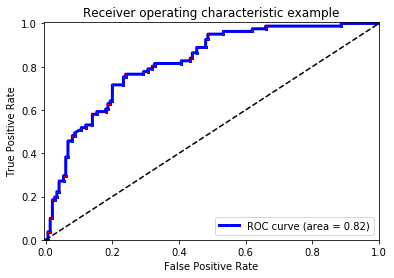

In [65]:
%matplotlib inline

plt.figure()
#plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, lw=4 ) # plot ROC curve, no marker
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, lw=3, color ="#0000ff", marker='s',markerfacecolor="red", markersize=2) 
plt.plot([0, 1], [0, 1], 'k--') # also plot black dashed line (k=black) from (0,0) to (1,1)

# Set x and y ranges, labels, title and legend
plt.xlim([-0.005, 1.0])  #x range basically from 0 to 1: start range a bit to left of min x value to see thick line better
plt.ylim([0.0, 1.005])   #0 range basically from 0 to 1: extend range a bit above max y value to see thick line better
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()